<h1>CS4618: Artificial Intelligence I</h1>
<h1>Data Preparation</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from pandas.tools.plotting import scatter_matrix

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# Class, for use in pipelines, to select certain columns from a DataFrame and convert to a numpy array
# From A. Geron: Hands-On Machine Learning with Scikit-Learn & TensorFlow, O'Reilly, 2017
# Modified by Derek Bridge to allow for casting in the same ways as pandas.DatFrame.astype
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, dtype=None):
        self.attribute_names = attribute_names
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_selected = X[self.attribute_names]
        if self.dtype:
            return X_selected.astype(self.dtype).values
        return X_selected.values

# Class, for use in pipelines, to binarize nominal-valued features (while avoiding the dummy variabe trap)
# By Derek Bridge, 2017
class FeatureBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, features_values):
        self.features_values = features_values
        self.num_features = len(features_values)
        self.labelencodings = [LabelEncoder().fit(feature_values) for feature_values in features_values]
        self.onehotencoder = OneHotEncoder(sparse=False,
            n_values=[len(feature_values) for feature_values in features_values])
        self.last_indexes = np.cumsum([len(feature_values) - 1 for feature_values in self.features_values])
    def fit(self, X, y=None):
        for i in range(0, self.num_features):
            X[:, i] = self.labelencodings[i].transform(X[:, i])
        return self.onehotencoder.fit(X)
    def transform(self, X, y=None):
        for i in range(0, self.num_features):
            X[:, i] = self.labelencodings[i].transform(X[:, i])
        onehotencoded = self.onehotencoder.transform(X)
        return np.delete(onehotencoded, self.last_indexes, axis=1)
    def fit_transform(self, X, y=None):
        onehotencoded = self.fit(X).transform(X)
        return np.delete(onehotencoded, self.last_indexes, axis=1)
    def get_params(self, deep=True):
        return {"features_values" : self.features_values}
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.setattr(parameter, value)
        return self

# Class, for use in pipelines, to impute missing values but which overcomes a problem that scikit-learn's class has
# when imputing modes on nominal-valued features
# From https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
# Original has a casting problem
# Fixed by Derek Bridge 2017
class MissingValueImputer(Imputer):
    def __init__(self, **kwargs):
        Imputer.__init__(self, **kwargs)
    def fit(self, X, y=None):
        if self.strategy == "most_frequent":
            self.fills = pd.DataFrame(X).mode(axis=0).squeeze() 
            return self
        else:
            return Imputer.fit(self, X, y=y)
    def transform(self, X):
        if hasattr(self, "fills"):
            return pd.DataFrame(X).fillna(self.fills).values
        else:
            return Imputer.transform(self, X)

<h1>Introductory Remarks</h1>
<ul>
    <li>Starting in the next lecture, we'll see how to train regressors and classifiers from a labeled dataset</li>
    <li>Before that, we need to say something about:
        <ul>
            <li>Dataset acquisition</li>
            <li>Dataset exploration</li>
            <li>Dataset preparation</li>
        </ul>
     </li>
     <li>Much of what we cover applies to unlabeled datasets too</li>
 </ul>

<h1>Dataset Acquisition</h1>
<ul>
    <li>Where will it come from? Existing databases and files? By scanning paper documents? By scraping web sites?
        &hellip;
    </li>
    <li>What quantities are available? How much do you need?</li>
    <li>What format is it in? What will you need to do to convert it?</li>
    <li>Are there legal or ethical issues: copyright, authorization, privacy? E.g. will you need to
        anonymize?
    </li>
    <li>If you need a labeled dataset, are the labels available? Are they reliable? How will you
        obtain them if not? (Get an expert? Get several experts? Use crowdsourcing?)
    </li>
    <li>If this were a data science module, there would be lots more to say on this!</li>
</ul>

<h1>Dataset Exploration</h1>
<ul>
    <li>Time spent just exploring the data is always worthwhile &mdash; especially if you have 
        access to a domain expert while you are doing so
    </li>
    <li>We've seen some parts of the pandas API that helps with this
        <ul>
            <li>To see features, their types, means/modes, how many distinct values, whether values are
                missing
            </li>
        </ul>
    </li>
    <li><b>Visualization</b> is a great help at this stage
        <ul>
            <li>Given a labeled dataset, we often want to see how target values or class labels are distributed 
                with respect to values of one or more of the features
            </li>
            <li>Given a labeled or unlabeled dataset, we might want to see how values of one feature are correlated with 
                values of one or more other features
            </li>
        </ul>
        A limitation is that visualizations are confined to two (or maybe three) dimensions
    </li>
    <li>We'll look at graphs and charts using matplotlib:
        <ul>
            <li>Scatter plots</li>
            <li>Histograms</li>
            <li>Box plots</li>
        </ul>
    </li>
    <li>To exemplify, we'll use two datasets:
        <ul>
            <li>A different version of the Cork Property Prices Dataset:
                <ul>
                    <li><code>dataset_corkB.csv</code> is the data that I actually scraped</li>
                    <li><code>dataset_corkA.csv</code> is a cleaned-up version that, for simplicity, we've been using 
                        up to now
                    </li>
                </ul>
            </li>
            <li>And a dataset we haven't seen before:
                <ul>
                    <li>I collected a dataset of student performances in a programming module (<i>CS1109</i>)</li>
                    <li>Three features: lecture attendance (%), lab attendance (%) and CAO points</li>
                    <li>Two classes: $0 = \mathit{pass}, 1 = \mathit{fail}$
                </ul>
            </li>
        </ul>
    </li>
</ul>

<h1>Exploring the Cork Property Prices Dataset</h1>

In [4]:
# Use pandas to read the CSV file into a DataFrame
cork_df = pd.read_csv("datasets/dataset_corkB.csv")

In [5]:
# The dimensions
cork_df.shape

(236, 9)

In [6]:
# The features
cork_df.columns

Index(['flarea', 'type', 'bdrms', 'bthrms', 'floors', 'devment', 'ber',
       'location', 'price'],
      dtype='object')

In [7]:
# The datatypes
cork_df.dtypes

flarea      float64
type         object
bdrms       float64
bthrms        int64
floors      float64
devment      object
ber          object
location     object
price       float64
dtype: object

In [8]:
# Summary statistics
cork_df.describe(include="all")

,flarea,type,bdrms,bthrms,floors,devment,ber,location,price
count,233.000000,236,234.000000,236.000000,233.000000,229,236,236,224.000000
unique,NaN,4,NaN,NaN,NaN,2,12,38,NaN
top,NaN,Detached,NaN,NaN,NaN,SecondHand,C3,CityCentre,NaN
freq,NaN,77,NaN,NaN,NaN,226,28,45,NaN
mean,145.458247,NaN,3.487179,2.161017,1.841202,NaN,NaN,NaN,307.714286
std,134.103000,NaN,1.226428,1.188386,0.366275,NaN,NaN,NaN,374.332421
min,0.371600,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,55.000000
25%,81.800000,NaN,3.000000,1.000000,2.000000,NaN,NaN,NaN,168.000000
50%,109.000000,NaN,3.000000,2.000000,2.000000,NaN,NaN,NaN,225.000000
75%,167.200000,NaN,4.000000,3.000000,2.000000,NaN,NaN,NaN,345.000000


<ul>
    <li>What problems do you see?</li>
</ul>

<ul>
    <li>For regression, we can have a <b>scatter plot</b> with target $y$ on the vertical axis and 
        a feature on the horizontal axis
    </li>
</ul>

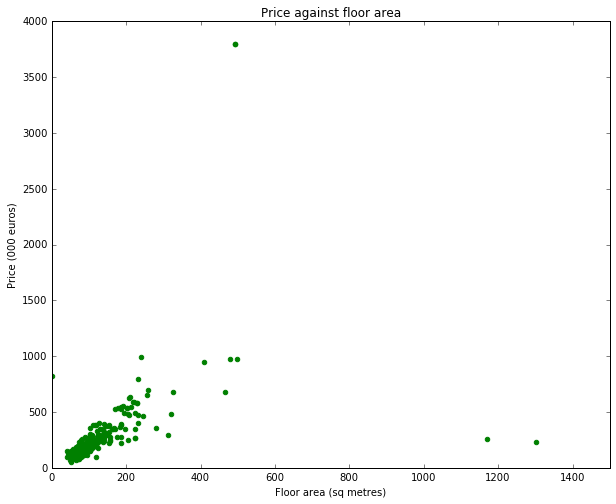

In [9]:
flareas = cork_df["flarea"]
prices = cork_df["price"]

fig = plt.figure(figsize=(10,8))
plt.title("Price against floor area")
plt.scatter(flareas, prices, color = "green")
plt.xlabel("Floor area (sq metres)")
plt.xlim(0, 1500)
plt.ylabel("Price (000 euros)")
plt.ylim(0, 4000)
plt.show()

<ul>
    <li>Any comments?</li>
</ul>

<ul>
    <li>And for any dataset (even an unlabeled one), we can plot one feature against another</li>
</ul>

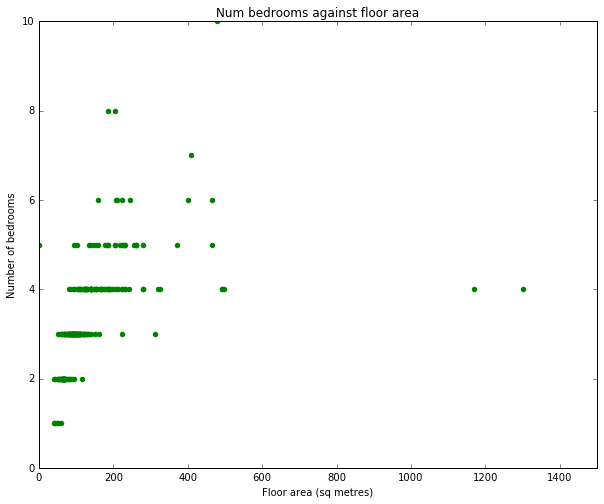

In [10]:
flareas = cork_df["flarea"]
bdrms = cork_df["bdrms"]

fig = plt.figure(figsize=(10,8))
plt.title("Num bedrooms against floor area")
plt.scatter(flareas, bdrms, color = "green") 
plt.xlabel("Floor area (sq metres)")
plt.xlim(0, 1500)
plt.ylabel("Number of bedrooms")
plt.ylim(0, 10)
plt.show()

<ul>
    <li>Any comments? Does this confrim anything we saw with this dataset in a previous lecture?</li>
</ul>

<ul>
    <li>A quick way to check for correlations is to use pandas' <code>scatter_matrix</code> function:
        <ul>
            <li>It plots every numeric-valued column against every other</li>
        </ul>
    </li>
</ul>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8fd8675160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f8fd58e3470>]], dtype=object)

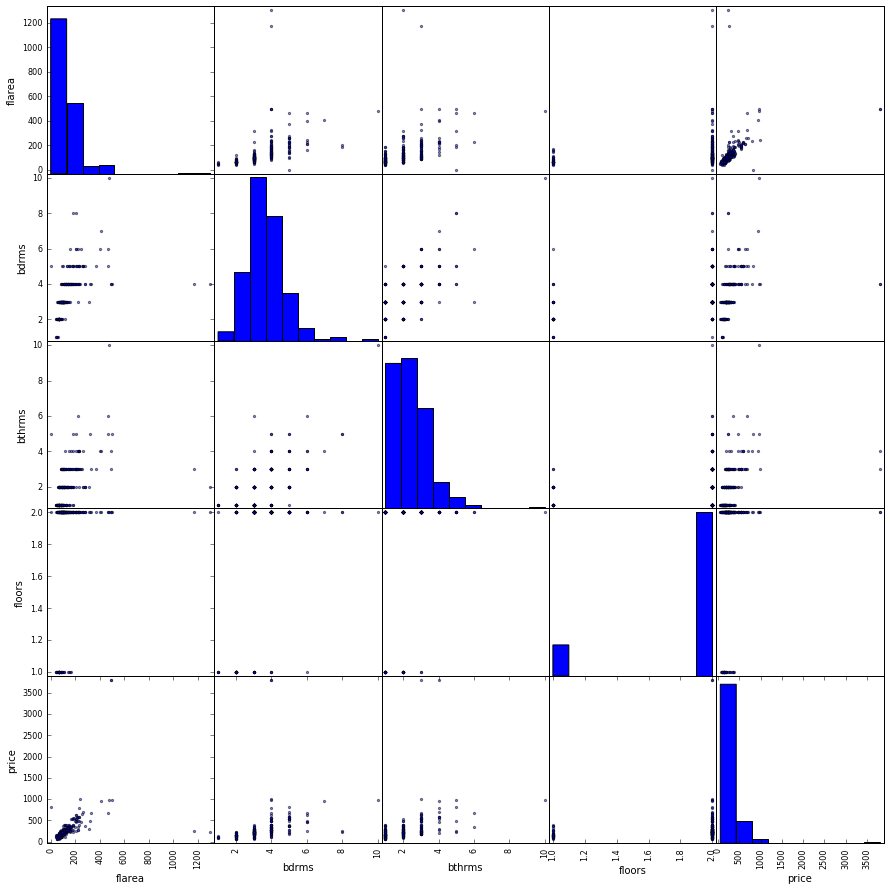

In [11]:
scatter_matrix(cork_df, figsize=(15, 15))

<ul>
    <li>The main diagonal above should be full of straight lines. Why?</li>
    <li>Since that wouldn't be useful, by default pandas shows a histogram of that column's values instead</li>
</ul>

<h1>Exploring the <i>CS1109</i> Dataset</h1>

In [12]:
# Use pandas to read the CSV file into a DataFrame
cs1109_df = pd.read_csv("datasets/dataset_cs1109.csv")

In [13]:
# The dimensions
cs1109_df.shape

(342, 4)

In [14]:
# The features
cs1109_df.columns

Index(['lect', 'lab', 'cao', 'outcome'], dtype='object')

In [15]:
# The datatypes
cs1109_df.dtypes

lect       int64
lab        int64
cao        int64
outcome    int64
dtype: object

In [16]:
# Summary statistics
cs1109_df.describe(include="all")

,lect,lab,cao,outcome
count,342.000000,342.000000,342.000000,342.000000
mean,78.970760,79.722222,395.877193,0.397661
std,22.590431,22.931276,60.705453,0.490132
min,0.000000,0.000000,215.000000,0.000000
25%,70.000000,73.000000,350.000000,0.000000
50%,86.000000,86.000000,390.000000,0.000000
75%,95.000000,95.000000,430.000000,1.000000
max,100.000000,100.000000,585.000000,1.000000


<ul>
    <li>A much cleaner dataset!</li>
</ul>

<ul>
    <li>For classification, we can show <em>two</em> features, one on each axis, with class labels
        shown using points of different shapes and colours
    </li>
</ul>

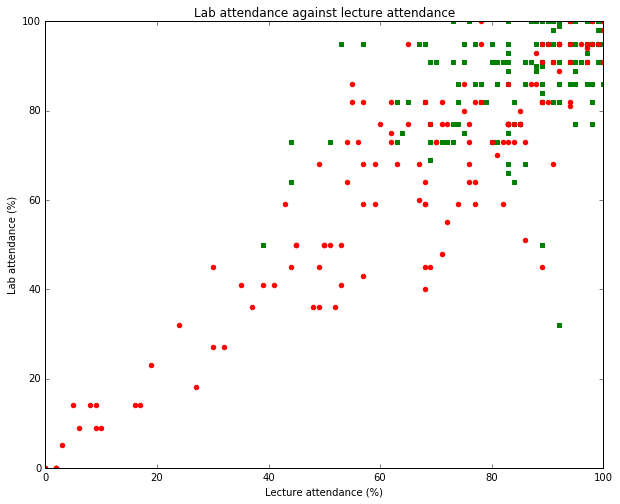

In [17]:
lects = cs1109_df["lect"]
labs = cs1109_df["lab"]
outcomes = cs1109_df["outcome"]

fig = plt.figure(figsize=(10,8))
plt.title("Lab attendance against lecture attendance")
plt.scatter(lects[outcomes==0], labs[outcomes==0], color = "green", marker="s")
plt.scatter(lects[outcomes==1], labs[outcomes==1], color = "red", marker="o")
plt.xlabel("Lecture attendance (%)")
plt.xlim(0, 100)
plt.ylabel("Lab attendance (%)")
plt.ylim(0, 100)
plt.show()

<ul>
    <li>For classification, given a feature, you could plot a <b>histograms</b> <em>per class</em></li>
</ul>

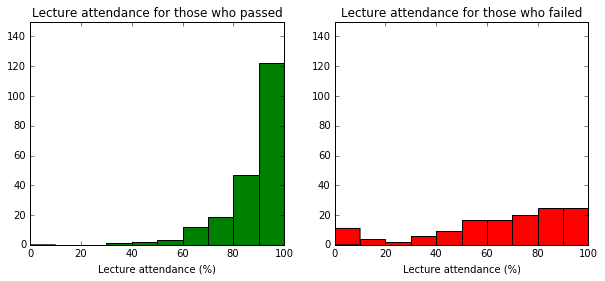

In [18]:
lects = cs1109_df["lect"]
outcomes = cs1109_df["outcome"]

fig = plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.title("Lecture attendance for those who passed")
plt.hist(lects[outcomes == 0], bins = range(0, 110, 10), color = "green")
plt.xlabel("Lecture attendance (%)")
plt.xlim(0, 100)
plt.ylim(0, 150)
plt.subplot(1, 2, 2)
plt.title("Lecture attendance for those who failed")
plt.hist(lects[outcomes == 1], bins = range(0, 110, 10), color = "red")
plt.xlabel("Lecture attendance (%)")
plt.xlim(0, 100)
plt.ylim(0, 150)
plt.show()

<ul>
    <li>Similarly, you could use a <b>box plot</b></li>
</ul>

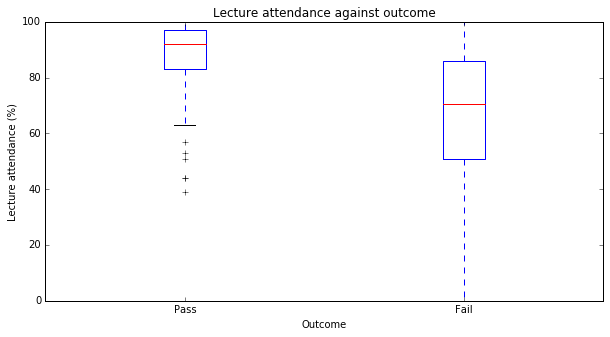

In [19]:
lects = cs1109_df["lect"]
outcomes = cs1109_df["outcome"]

fig = plt.figure(figsize=(10, 5))
ax = plt.axes()
plt.title("Lecture attendance against outcome")
plt.boxplot([lects[outcomes == 0], lects[outcomes == 1]])
plt.xlabel("Outcome")
plt.ylabel("Lecture attendance (%)")
plt.ylim(0, 100)
ax.set_xticklabels(["Pass", "Fail"])
plt.show()

<ul>
    <li>
        The bottom of the box is the <b>first quartile</b>
        <ul>
            <li>25% of the data has values lower than this</li>
        </ul>
    </li>
    <li>
        The red line inside the box is the second quartile (the <b>median</b>)
        <ul>
            <li>50% of the data has values lower than this</li>
        </ul>
    </li>
    <li>
        The top of the box is the <b>third quartile</b>
        <ul>
            <li>75% of the data has lower values than this</li>
        </ul>
    </li>
    <li>
        The difference between the third quartile and the first quartile is called the <b>inter-quartile range</b> (IQR)
    </li>
    <li>
        By default, the <b>whiskers</b> show the lowest value still within 1.5 IQR of the first quartile, and the highest value 
        still within 1.5 IQR of the third quartile
    </li>
    <li>
        Any other values ('outliers' or 'fliers') beyond the whiskers are shown individually
    </li>
</ul>

<h1>Dataset Preparation</h1>
<ul>
    <li>Before you throw learning algorithms at your data, there is the task of <b>data preparation</b>
        <ul>
            <li>Real data is incomplete (e.g. with values missing), noisy (containing errors) 
                and inconsistent (especially if it comes from multiple sources)
            </li>
            <li>We must deal with at least some of these problems before applying any learning 
                algorithms (otherwise, garbage-in-garbage-out)
            </li>
            <li>People estimate that data preparation accounts for 60% or more of the work in data analytics</li>
        </ul>
    </li>
    <li>An incomplete list of data preparation activities (in no particular order):
        <ul>
            <li>Data cleaning:
                <ul>
                    <li>handling missing values; smoothing noisy data; removing outliers; correcting 
                        erroneous values; &hellip;
                    </li>
                </ul>
            </li>
            <li>Data integration:
                <ul>
                    <li>de-normalizing relational databases and flattening other data structures such as trees
                        and graphs; resolving inconsistencies; identifying and handling duplicates; &hellip;
                    </li>
                </ul>
            </li>
            <li>Data transformation:
                <ul>
                    <li>binarizing nominal values; discretizing numeric values;
                        changing character encodings; scaling; &hellip;
                    </li>
                </ul>
            </li>
            <li>Feature engineering:
                <ul>
                    <li>augmenting the dataset with new features, either newly-gathered features or ones that 
                        are computed from the other features (e.g. aggregates of the others); &hellip;
                    </li>
                </ul>
            </li>
            <li>Data reduction:
                <ul>
                    <li>sampling (e.g. to use a subset of the examples if the dataset is tooo large to handle);
                        feature selection to remove features with low predictive power; reducing the
                        dimensionality of the data through techniques such as Principal Component Analysis;
                        &hellip;
                    </li>
                </ul>
             </li>
        </ul>
    </li>
    <li>Automate these processes so that you can apply them to fresh data in the future
        <ul>
            <li>Some things you'll do in advance on the whole dataset: we'll use pandas for this</li>
            <li>Some things are best done in your pipelines: we use scikit-learn for this</li>
        </ul>
    </li>
    <li>We'll look at how to handle anomalous values and missing values below</li>
</ul>

<h1>Anomalous Values</h1>
<ul>
    <li>Most datasets are noisy
        <ul>
            <li>
                People supply incorrect data; e.g. see the $\mathit{flarea}$ example above
            </li>
            <li>
                They make spelling mistakes
                <ul>
                    <li>In nominal-valued data, this can lead to a proliferation of values,
                        where there should be fewer
                    </li>
                    <li>E.g. "Sunday's Well", "Sundays' Well", "Sundays Well",
                        "Sunday Wells", "Sundays Wells", "Sundays well" will, from an algorithm's point of view, all be
                        different locations
                    </li>
                </ul>
            </li>
            <li>
                They make typing errors
            </li>
            <li>
                Software that has been instrumented to measure, e.g., user actions (number of clicks, response times,
                etc.) may be buggy
            </li>
            <li>
                Measuring equipment may malfunction
            </li>
            <li>
                &hellip;
        </li>
    </ul>
    <li>Noise can affect the feature values or, in labeled dataset, the target values/class labels
    </li>
</ul>

<h2>Detecting anomalous values</h2>
<ul>
    <li>If it matters a lot, you can do lots of manual checking &mdash; but that's costly</li>
    <li>There are also some automatic methods that can help with anomaly detection based on probability distributions 
        &mdash; but we don't have time to examine these
    </li>
    <li>As we saw, visualizations can help reveal possible anomalies &mdash; ideally, you check them with your domain
        expert
        <ul>
            <li>Simple graphs like the one above will not reveal all anomalous data. What kinds of anomalies will
                fail to show up?
            </li>
        </ul>
    </li>
</ul>

<h2>Handling anomalous values</h2>
<ul>
    <li>You must either correct them &mdash; if you can without undue effort</li>
    <li>Or you'll have to delete examples (rows) that contain anomalous values</li>
</ul>

In [20]:
# Delete examples from the Cork Property Prices Dataset whose floor areas are too small or too big

cork_df = (cork_df[(cork_df["flarea"].isnull()) | ((cork_df["flarea"] > 10) & (cork_df["flarea"] < 1000))]).copy()
cork_df.reset_index(drop=True, inplace=True)

# Check the anomalies were filtered out
cork_df.shape

(233, 9)

<h1>Missing Values</h1>
<ul>
    <li>Many datasets contain examples that are missing the values of some of the features
    </li>
    <li>The simple case
        <ul>
            <li>In a CSV file, they appear as the empty string</li>
            <li>When pandas reads the file, it stores them as NaN</li>
        </ul>
    </li>
    <li>But you might receive a file that doesn't use the empty string
        <ul>
            <li>They might appear instead as whitespace, or a dash, or '?', or 'UNK', or 'N/A', or some other special
                value
            </li>
        </ul>
    </li>
    <li>
        For a numeric-valued feature, they might appear using the same strings that we
        have just mentioned, or an out-of-range number might be used (0, -1,...)
    </li>
</ul>

<h2>Why May Values be Missing?</h2>
<ul>
    <li>
        Inapplicable feature: the value is missing because it does not apply to this object
        <ul>
            <li>E.g. a feature that records how many weeks pregnant someone is only applies to people who are
                pregnant
            </li>
            <li>E.g. if you are feeding mice for ten weeks in a lab experiment and measuring their weight
                at the end of each week, then you will have ten features for each mouse; but if a mouse dies 
                before the end of the experiment one or more of its ten features will have missing values
            </li>
        </ul>
    </li>
    <li>
        Value not recorded: there is a value but it is not recorded in the dataset
        <ul>
            <li>E.g. a person filling in a survey refuses to give his/her sex or income</li>
            <li>E.g. a student does not know what CAO points s/he attained</li>
            <li>E.g. the mouse survives but we forget to weigh it or the measuring equipment malfunctions in week 4, 
                so that value is missing
            </li>
        </ul>
    </li>
    <li>
        Status unknown: the value is missing but we don't know which of the previous two is the case
        <ul>
            <li>E.g. the mouse's weight for week 10 is missing: is it because the mouse died at the end of week
                9 (so the value for week 10 is inapplicable) or is it because we forgot to measure it?
            </li>
        </ul>
    </li>
    <li>But there can be domain-specific reasons why values are missing
        <ul>
            <li>E.g. a student assignment may be scored out of ten (including zero, meaning the work was submitted 
                but was worthless). But you might want to distinguish the following cases where the value is missing: 
                the student did not submit (for no good reason), the student did not submit for good reason (e.g. illness)
                so the assignment is written off, or the student plagiarised the work
            </li>
        </ul>
    </li>
    <li>
        If you're really lucky, the dataset might use different symbols for these different cases!
    </li>
</ul>

<h2>Handling Missing Values</h2>
<ul>
    <li>While there are exceptions, most learning algorithms will expect a value for each feature</li>
    <li>What can we do?
        <ul>
            <li>Revisit the data acquisition process:
                <ul>
                    <li>In a few cases, it might be possible, perhaps with some cost and effort, to
                        obtain some of the missing values
                    </li>
                </ul>
            </li>
            <li>Delete examples:
                <ul>
                    <li>If only a small proportion of the examples in the dataset contain features with missing values, 
                        then you could simply delete those <em>rows</em>
                    </li>
                    <li>In which column is a missing value particularly problematic? If you can't obtain the missing
                       values, you will probably have to delete these examples
                    </li>
                </ul>
            </li>
            <li>Delete features:
                <ul>
                    <li>If one or two of the features are plagued by missing values, then we could simply delete those
                        <em>columns</em>
                    </li>
                </ul>
            </li>
            <li>Impute a value:
                <ul>
                    <li>For numeric-valued features, you can use the mean (or median) of the values that are not missing,
                        e.g. the average floor area
                    </li>
                    <li>For nominal-valued features, you can use the mode (i.e. the most
                        frequent of the values that are not missing)
                    </li>
                    <li>You might instead have some domain-specific way of imputing values that you can agree with your 
                        domain expert
                        <ul>
                            <li>Returning again to the example of the weights of mice, if a mouse is missing the value 
                                for week 4 but its values for weeks 3 and 5 are present, then you could take the average 
                                of its week 3 and 5 values, rather than the average of the week 4 values for all the other 
                                mice
                            </li>
                        </ul>
                    </li>
                </ul>
            </li>
        </ul>
    </li>
</ul>

In [21]:
# Example of deleting examples - ones where a feature (in this case, flarea) is NaN

cork_df.dropna(subset=["flarea"], inplace=True)
cork_df.reset_index(drop=True, inplace=True)

# Check the examples with missing values were removed
cork_df.shape

(230, 9)

In [22]:
# And the same again for price

cork_df.dropna(subset=["price"], inplace=True)
cork_df.reset_index(drop=True, inplace=True)

# Check the examples with missing values were removed
cork_df.shape

(218, 9)

In [23]:
# Example of deleting examples - in this case, we're pretending that type has missing values (it doesn't) and that
# they appear as a special value: "?"

cork_df = (cork_df[cork_df["type"] != "?"]).copy()
cork_df.reset_index(drop=True, inplace=True)

# Check the anomalies were filtered out
cork_df.shape

(218, 9)

In [24]:
# Example of deleting a feature (in this case, ber) - where we are pretending it contains so many missing values that 
# it is worthless

cork_df.drop('ber', axis=1, inplace=True)

# Check the feature was removed
cork_df.shape

(218, 8)

<ul>
    <li>To impute a value, I have supplied <code>MissingValueImputer</code> (based on scikit-learn's 
        <code>Imputer</code> class)
    </li>
    <li>This should be done in a pipeline</li>
</ul>

<h1>Putting it all together</h1>
<ul>
    <li>Here's what I would do with the Cork dataset</li>
</ul>

In [25]:
cork_df = pd.read_csv("datasets/dataset_corkB.csv")

In [26]:
cork_df = (cork_df[(cork_df["flarea"].isnull()) | ((cork_df["flarea"] > 10) & (cork_df["flarea"] < 1000))]).copy()
cork_df = (cork_df[(cork_df["price"].isnull()) | (cork_df["price"] < 1500)]).copy()

cork_df.dropna(subset=["price"], inplace=True)

cork_df.reset_index(drop=True, inplace=True)

In [27]:
numeric_features = ["flarea", "bdrms", "bthrms", "floors"]
nominal_features = ["type", "devment", "ber", "location"]
nominal_features_values = [["Detached", "Semi-detached", "Terraced", "Apartment"],
                            ["SecondHand", "New"],
                            ["B2", "D2", "C3", "D1", "F", "E2", "C1", "C2", "G", "B3", "E1", "B1"],
                            ["Carrigrohane", "Glanmire", "Blackrock", "Douglas", "CityCentre",
                             "Silversprings", "PassageWest", "Ballinlough", "Farranree",
                             "Rochestown", "Inniscarra", "Blackpool", "Waterfall", "Bishopstown",
                             "Donnybrook", "Wilton", "Togher", "Grange", "Mayfield", "Glasheen",
                             "TheLough", "Ballyvolane", "ModelFarmRoad", "TurnersCross",
                             "WesternRoad", "Ovens", "Cloghroe", "Ballintemple", "Montenotte",
                             "Fota", "Ballyphehane", "DublinPike", "StLukes", "VictoriaCross",
                             "Banduff", "Gurranabraher"]]

numeric_pipeline = Pipeline([
        ("selector", DataFrameSelector(numeric_features)),
        ("imputer", MissingValueImputer(missing_values="NaN", strategy="mean")),
        ("scaler", StandardScaler())
    ])

nominal_pipeline = Pipeline([
        ("selector", DataFrameSelector(nominal_features)), 
        ("imputer", MissingValueImputer(missing_values="NaN", strategy="most_frequent")), 
        ("binarizer", FeatureBinarizer(nominal_features_values))
])

pipeline = Pipeline([("union", FeatureUnion([("numeric_pipeline", numeric_pipeline), 
                                             ("nominal_pipeline", nominal_pipeline)]))])

In [28]:
# Run the pipeline
pipeline.fit(cork_df)
X = pipeline.transform(cork_df)

<ul>
    <li>We deleted anomalous values before imputing means. Why?</li>
    <li>We imputed means/modes before scaling. Why?</li>   
</ul>